<a href="https://colab.research.google.com/github/OjasKhandelwal/LearnML/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GRAPH CONVOLUTION NETWORK


##Analysing a Social Network using GNN

###Classifying the students of a university based on the countries they come from. It is observed that students from the same country tend to interact more. Based on this pattern, we will use a Graph Convolutional Network (GCN) to classify the students.

In [3]:
!pip install torch_geometric  #provides necessary tools & layers for implementing GNNs
!pip install optuna    #hyperparameter optimization library

In [8]:
import torch
from torch_geometric.datasets import KarateClub   #we are using karateclub dataset , which is already in the library
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx  #used for creating , manipulating & analysing nodes & edges of a graph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Linear  #used to define layers of our gcn
import pandas as pd

In [6]:
#Load the karate club dataset
dataset = KarateClub()
data = dataset[0]

In [7]:
print(dataset.num_features)

34


In [10]:

#convert node features to a pandas dataframe
node_features_df = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])])
node_features_df['node'] = node_features_df.index
node_features_df.set_index('node', inplace=True)

# Convert edge indices to a pandas DataFrame
edge_index_df = pd.DataFrame(data.edge_index.numpy().T,columns=['source', 'target'])

#convert labels to a pandas dataframe
labels_df = pd.DataFrame(data.y.numpy(), columns=['label'])
labels_df['node'] = labels_df.index
labels_df.set_index('node', inplace=True)

In [11]:
print(node_features_df)

      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   
5           0.0        0.0        0.0        0.0        0.0        1.0   
6           0.0        0.0        0.0        0.0        0.0        0.0   
7           0.0        0.0        0.0        0.0        0.0        0.0   
8           0.0        0.0        0.0        0.0        0.0        0.0   
9           0.0        0.0        0.0        0.0        0.0        0.0   
10          0.0        0.0        0.0        0.0        0.0        0.0   
11          0.0        0.0        0.0 

In [12]:
num_nodes = data.num_nodes
print(f"no. of nodes : {num_nodes}")

num_edges = data.num_edges
print(f"no. of edges : {num_edges}")

num_features = data.num_features
print(f"no. of features : {num_features}")

no. of nodes : 34
no. of edges : 156
no. of features : 34


In [13]:
print(f"\nNode features (shape: {node_features_df.shape}):")
print(node_features_df.head())


Node features (shape: (34, 34)):
      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   

      feature_6  feature_7  feature_8  feature_9  ...  feature_24  feature_25  \
node                                              ...                           
0           0.0        0.0        0.0        0.0  ...         0.0         0.0   
1           0.0        0.0        0.0        0.0  ...         0.0         0.0   
2           0.0        0.0        0.0        0.0  ...         0.0         0.0   
3           0.0        0.0        0.0     

In [14]:
print(f"\nEdge indices (shape: {edge_index_df.shape}):")
print(edge_index_df.head())


Edge indices (shape: (156, 2)):
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [15]:
print(f"\nLabels (shape: {labels_df.shape}):")
print(labels_df.head())


Labels (shape: (34, 1)):
      label
node       
0         1
1         1
2         1
3         1
4         3


In [29]:
  #no. of countries
num_countries = 4

#assign students to countries(labels)
np.random.seed(42)  #for reproductibility
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))

#update the labels in the data object
data.y = countries

In [30]:
#verify the data
print(data)
print(f"x = {data.x.shape}")
print(data.x)
print(f"edge_index = {data.edge_index.shape}")
print(data.edge_index)
print(f"y = {data.y.shape}")
print(data.y)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

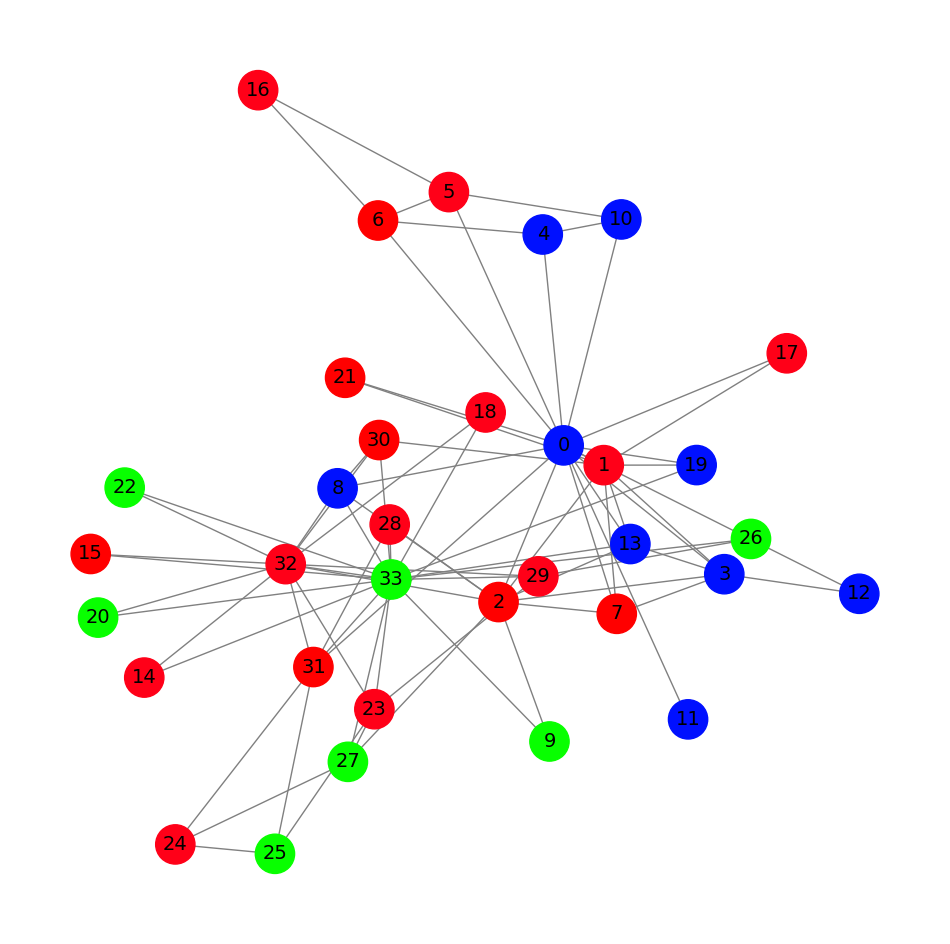

In [31]:
#check if the graph is as expected
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis("off")
nx.draw(
    G,
    pos=nx.spring_layout(G, k=0.15, iterations=20),
    with_labels=True,
    node_size=800,
    node_color=data.y.numpy(),   # ensure it's a NumPy array
    cmap="hsv",                  # color map for distinct colors
    edge_color="grey",
    font_size=14
)
plt.show()

In [37]:
#define the model
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.gcn = GCNConv(dataset.num_features, 3)
    self.out = Linear(3, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.gcn(x, edge_index).relu()
    z = self.out(h)
    return z, h


model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

#calculate accuracy
def accuracy(pred_y , y):
  return (pred_y == y).sum().item() / len(y)

In [42]:
# Lists to store training progress
embeddings = []
losses = []
accuracies = []
outputs = []

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Accuracy function
def accuracy(pred, target):
    return (pred == target).sum().item() / len(target)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    z, h = model(data.x, data.edge_index)

    # Compute loss
    loss = criterion(z, data.y)

    # Compute accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Save results for animation (detach to save memory)
    embeddings.append(h.detach())
    losses.append(loss.item())
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1).detach())

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:>3}, Loss: {loss:.4f}, Accuracy: {acc*100:.2f}%")


Epoch:   0, Loss: 1.4318, Accuracy: 26.47%
Epoch:  10, Loss: 1.3789, Accuracy: 26.47%
Epoch:  20, Loss: 1.3320, Accuracy: 32.35%
Epoch:  30, Loss: 1.2800, Accuracy: 32.35%
Epoch:  40, Loss: 1.2164, Accuracy: 38.24%
Epoch:  50, Loss: 1.1436, Accuracy: 55.88%
Epoch:  60, Loss: 1.0539, Accuracy: 70.59%
Epoch:  70, Loss: 0.9515, Accuracy: 79.41%
Epoch:  80, Loss: 0.8459, Accuracy: 82.35%
Epoch:  90, Loss: 0.7444, Accuracy: 88.24%


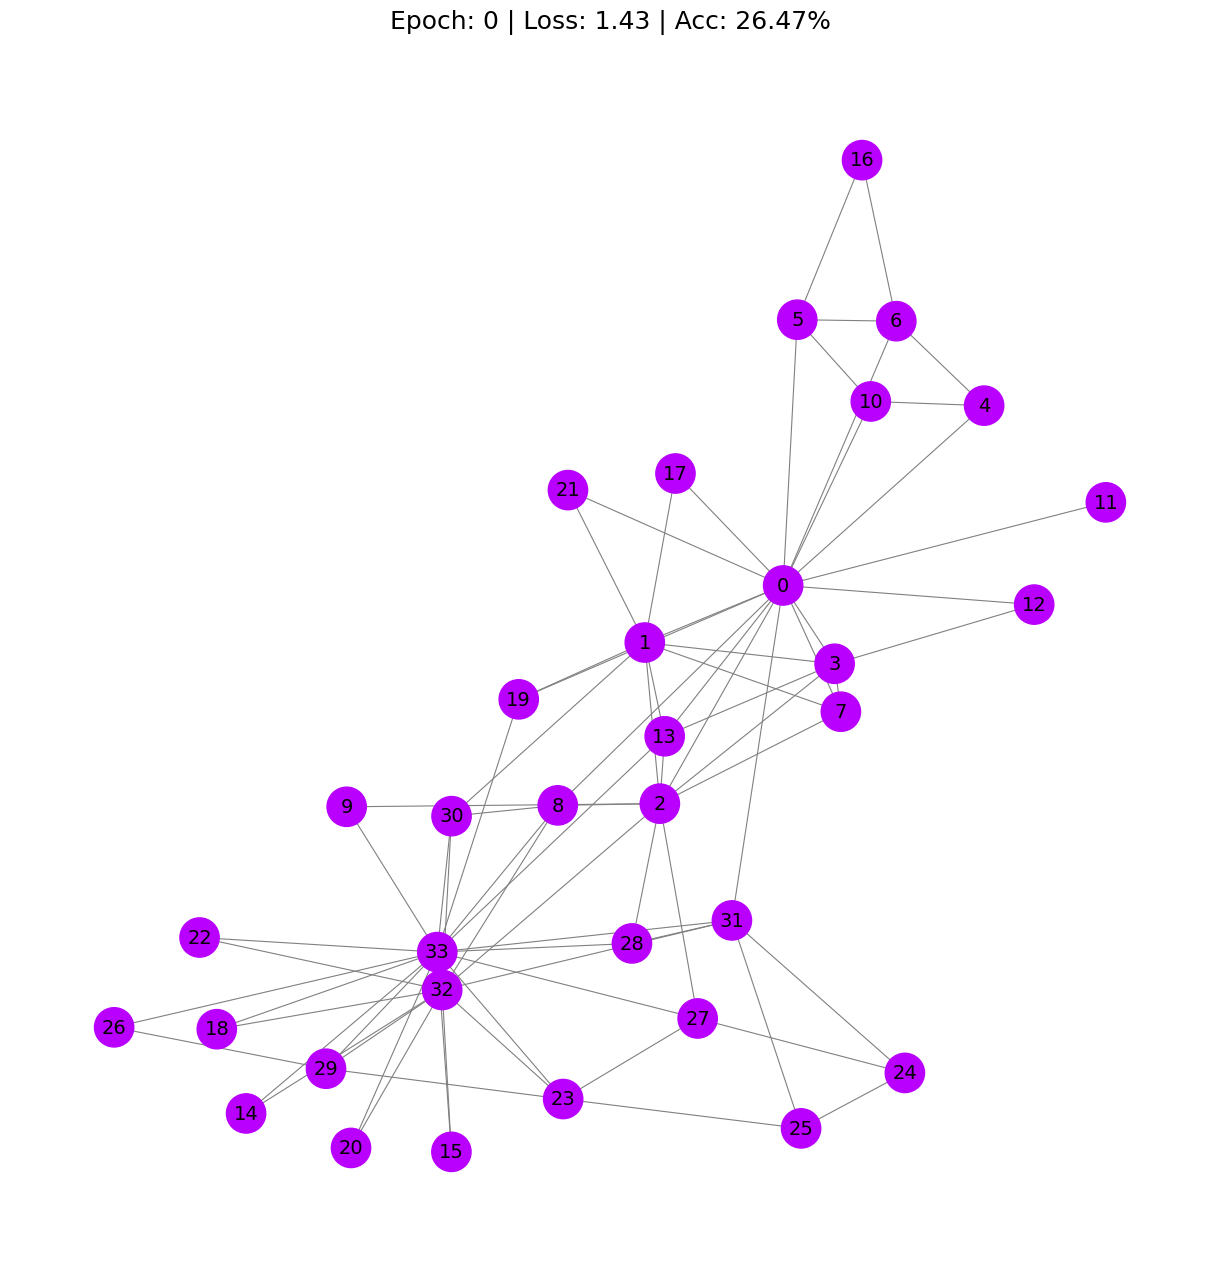

In [45]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import HTML, display
from matplotlib import animation
from torch_geometric.utils import to_networkx

# Optional: make the animation smoother
plt.rcParams["animation.bitrate"] = 3000

# Create figure
fig = plt.figure(figsize=(12, 12))
plt.axis('off')

# Precompute layout once (to keep node positions stable)
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=20)

# Define the animation function
def animate(i):
    plt.clf()  # Clear previous frame
    nx.draw(
        G,
        pos=pos,
        with_labels=True,
        node_size=800,
        node_color=outputs[i].numpy(),  # Predicted class colors
        cmap="hsv",
        vmin=-2,
        vmax=3,
        width=0.8,
        edge_color="grey",
        font_size=14
    )
    plt.title(f'Epoch: {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

# Build the animation
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=np.arange(0, len(outputs), 10),  # one frame every 10 epochs
    interval=500,
    repeat=True
)

# Display animation in notebook
html = HTML(anim.to_html5_video())
display(html)


Final embeddings = torch.Size([34, 3])
tensor([[0.0000e+00, 3.6466e-01, 4.6849e-01],
        [1.8816e-01, 4.8134e-01, 6.9890e-02],
        [5.5295e-01, 0.0000e+00, 8.6024e-02],
        [0.0000e+00, 6.3022e-02, 4.0393e-01],
        [4.4267e-03, 2.1065e-01, 6.7824e-01],
        [2.7412e-01, 8.1192e-01, 4.3043e-02],
        [2.4417e-01, 4.4985e-01, 1.1554e-03],
        [1.3291e-01, 3.4390e-02, 1.6958e-02],
        [2.6637e-01, 1.4782e-01, 3.1773e-01],
        [1.0941e+00, 0.0000e+00, 8.4479e-01],
        [1.1652e-03, 2.0297e-01, 5.4104e-01],
        [3.0267e-04, 3.5875e-02, 8.8586e-01],
        [0.0000e+00, 1.3806e-02, 5.2489e-01],
        [7.2323e-02, 2.6398e-01, 4.7839e-01],
        [1.0021e+00, 7.5506e-01, 8.0353e-02],
        [6.2912e-01, 4.6659e-03, 2.7257e-04],
        [4.9973e-01, 8.6686e-01, 0.0000e+00],
        [6.0972e-01, 4.5121e-01, 0.0000e+00],
        [1.1800e+00, 5.8393e-01, 1.8111e-02],
        [8.7291e-02, 2.7106e-01, 6.0525e-01],
        [1.0723e+00, 4.5243e-04, 7.2218e-

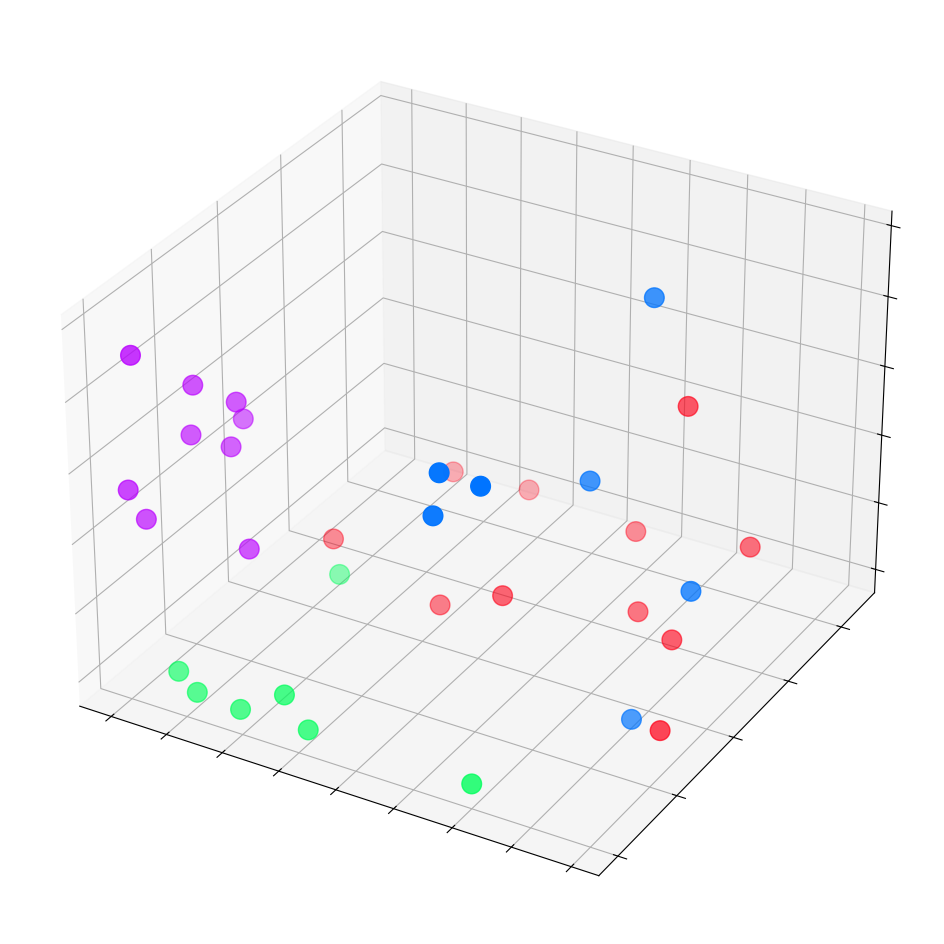

In [50]:
# 3D Embeddings Visualization
print(f'Final embeddings = {h.shape}')
print(h)

embed = h.detach().cpu().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()


